## Project IMPACT Covid Cases by Zip Code in Chicago 5/29/2020

### Purpose is to develop an infographic from the data that will show specific Chicago areas where Covid cases are recorded

#### https://data.cityofchicago.org/Health-Human-Services/COVID-19-Cases-Tests-and-Deaths-by-ZIP-Code/yhhz-zm2v

#### Each row is a Week of COVID-19 Metrics for a ZIP Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import calendar
import datetime
import seaborn as sns
from osgeo import gdal, ogr, osr
from fiona.ogrext import Iterator, ItemsIterator, KeysIterator
import geopandas as gpd
from geopandas import GeoDataFrame
import descartes
from shapely.geometry import Point, Polygon
import plotly.figure_factory as ff

In [2]:
#Get the map file from the Chicago Data Portal
zip_map = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=Shapefile')

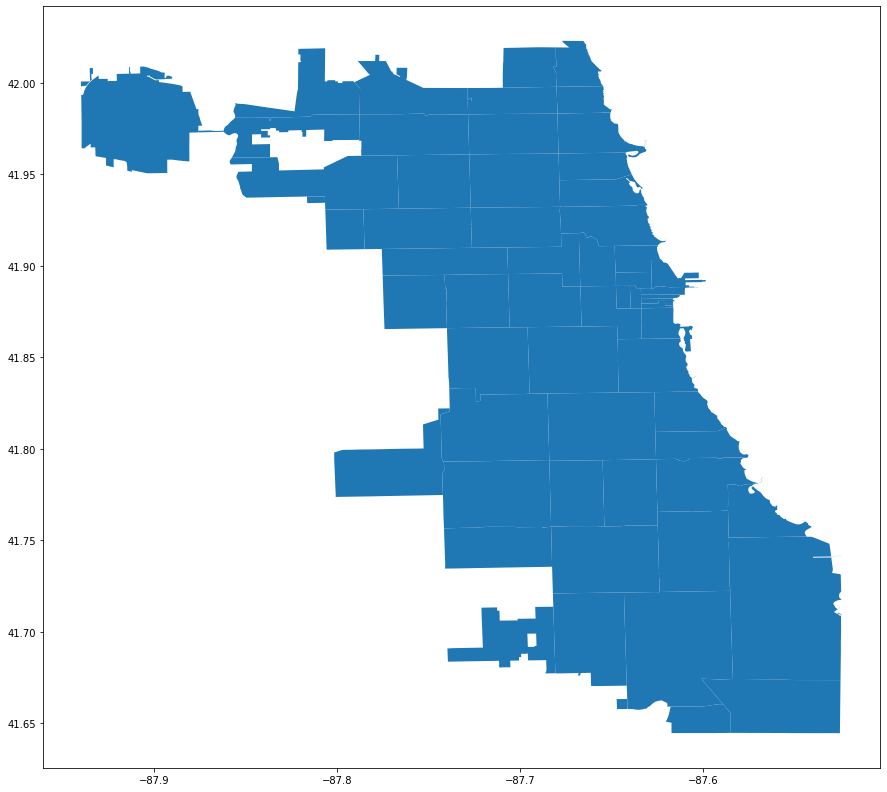

In [3]:
#Import the map, call it zip_map
fig, ax = plt.subplots(figsize = (15,15))
zip_map.plot(ax=ax)

In [4]:
#Get the dataset https://data.cityofchicago.org/Health-Human-Services/COVID-19-Cases-Tests-and-Deaths-by-ZIP-Code/yhhz-zm2v as of 5/13/20
covid = pd.read_csv(('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code-5-29-20.csv'))

In [6]:
covid.head(1) #All the blanks in the csv file are NaN here and need to be filled in.
#Note that ZIP Code Location with POINT, Longitude, Latitude has already been done which will save time on geometry later

,ZIP Code,community,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60601,LOOP,12,3/15/2020,3/21/2020,8.0,11,54.0,75,32,...,265.8,0.3,0.4,0,0,0.0,0.0,"14,675",60601-12,POINT (-87.622844 41.886262)


In [7]:
covid.describe()

,Week Number,Cases - Weekly,Case Rate - Weekly,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative
count,720.000000,566.000000,566.000000,573.000000,573.000000,720.000000,720.000000,720.000000,720.000000
mean,15.500000,75.378092,135.584806,0.237696,0.261780,2.808333,12.094444,5.157222,22.302639
std,3.454452,93.542523,116.198544,0.122230,0.096919,4.032129,18.537770,7.589375,32.924741
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.750000,17.000000,50.250000,0.100000,0.200000,0.000000,0.000000,0.000000,0.000000
50%,15.500000,46.000000,106.500000,0.200000,0.300000,1.000000,2.000000,1.800000,5.350000
75%,18.250000,95.750000,186.750000,0.300000,0.300000,5.000000,18.000000,7.800000,33.025000
max,21.000000,628.000000,730.000000,0.700000,0.500000,23.000000,105.000000,64.500000,197.700000


In [8]:
#The missing values are due to data not available until there are >=5 cases, so replace the blanks with 0
covid.replace(np.nan, 0, inplace = True)

In [9]:
#Convert the Cases - Weekly and Cases - Cumulative from float to integer format
covid["Cases - Weekly"] = covid["Cases - Weekly"].astype(int)
#No issue with this

In [10]:
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].fillna(0)
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].str.replace(",","")
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].str.replace(" ","")
#covid["Cases - Cumulative"] = covid["Cases - Cumulative"].astype("float")
#From Thinkful technical coaching
#You were getting the error because the decimal separator in that field is comma (,). Use the following code:


In [11]:
covid["Cases - Cumulative"].replace(np.nan, 0, inplace = True)

In [15]:
covid["Case Rate - Cumulative"] = covid["Case Rate - Cumulative"].str.replace(",","")
covid["Case Rate - Cumulative"] = covid["Case Rate - Cumulative"].str.replace(" ","")

In [16]:
covid["Case Rate - Cumulative"].replace(np.nan, 0, inplace = True)

In [17]:
covid["Case Rate - Cumulative"] = covid["Case Rate - Cumulative"].astype(float)

In [18]:
covid["Case Rate - Cumulative"].dtype

dtype('float64')

In [19]:
import plotly_express as px

In [26]:
covid21 = covid[covid['Week Number']==21]
covid21 = covid21[covid21['community']!=0]

In [27]:
covid21

,ZIP Code,community,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
9,60601,LOOP,21,5/17/2020,5/23/2020,1,67,7.0,456.6,69,...,"3,284.50",0.0,0.1,0,4,0.0,27.3,"14,675",60601-21,POINT (-87.622844 41.886262)
20,60602,LOOP,21,5/17/2020,5/23/2020,2,11,161.0,884.2,17,...,"7,074",0.2,0.1,0,0,0.0,0.0,"1,244",60602-21,POINT (-87.628309 41.883136)
35,60603,LOOP,21,5/17/2020,5/23/2020,1,7,85.0,596.3,9,...,"4,173.80",0.1,0.2,0,0,0.0,0.0,"1,174",60603-21,POINT (-87.625473 41.880112000000004)
40,60604,LOOP,21,5/17/2020,5/23/2020,1,18,128.0,2301.8,11,...,"9,718.70",0.2,0.2,0,0,0.0,0.0,782,60604-21,POINT (-87.62902900000002 41.878153)
54,60605,NEAR SOUTH SIDE,21,5/17/2020,5/23/2020,11,161,40.0,585.1,175,...,"4,280.70",0.1,0.1,0,1,0.0,3.6,"27,519",60605-21,POINT (-87.623449 41.867824)
71,60606,LOOP,21,5/17/2020,5/23/2020,2,45,64.0,1451.1,73,...,"12,383.10",0.0,0.1,0,2,0.0,64.5,"3,101",60606-21,POINT (-87.63676 41.882634)
80,60607,NEAR WEST SIDE,21,5/17/2020,5/23/2020,16,408,54.0,1378.8,185,...,"5,396.90",0.1,0.3,0,5,0.0,16.9,"29,591",60607-21,POINT (-87.652727 41.876104)
94,60608,LOWER WEST SIDE,21,5/17/2020,5/23/2020,139,1475,176.0,1862.3,618,...,"5,922.60",0.2,0.3,5,43,6.3,54.3,"79,205",60608-21,POINT (-87.670366 41.849879)
106,60609,NEW CITY,21,5/17/2020,5/23/2020,237,1517,385.0,2466.9,777,...,"6,927.40",0.3,0.4,5,47,8.1,76.4,"61,495",60609-21,POINT (-87.653382 41.812017)
118,60610,NEAR NORTH SIDE,21,5/17/2020,5/23/2020,25,227,64.0,581.8,322,...,"4,413.20",0.1,0.1,1,6,2.6,15.4,"39,019",60610-21,POINT (-87.63581 41.90455)


In [35]:
covid21['zip'] = covid21['ZIP Code']
covid21 = covid21[["zip", "community", "Case Rate - Cumulative"]]

In [36]:
zip_map

,objectid,shape_area,shape_len,zip,geometry
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917..."
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922..."
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909..."
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895..."
...,...,...,...,...,...
56,57.0,1.552855e+08,53406.915617,60623,"POLYGON ((-87.69479 41.83008, -87.69486 41.830..."
57,58.0,2.111148e+08,58701.325375,60629,"POLYGON ((-87.68306 41.75786, -87.68306 41.757..."
58,59.0,2.116961e+08,58466.160298,60620,"POLYGON ((-87.62373 41.72167, -87.62388 41.721..."
59,60.0,1.254243e+08,52377.854541,60637,"POLYGON ((-87.57691 41.79511, -87.57700 41.795..."


In [37]:
#merged = map_df.set_index('NAME').join(data_for_map.set_index('borough'))
#merged = zip_map.set_index('zip').join(gdf19.set_index('ZIP Code'))
merged = zip_map.merge(covid21, on='zip', how='left')

In [38]:
merged.head()

,objectid,shape_area,shape_len,zip,geometry,community,Case Rate - Cumulative
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",LOGAN SQUARE,1331.3
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",BELMONT CRAGIN,3111.0
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909...",MONTCLARE,416.1
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",WEST TOWN,1075.9
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895...",HUMBOLDT PARK,2314.2


In [39]:
merged["Case Rate - Cumulative"] = merged["Case Rate - Cumulative"].astype(int)

In [40]:
merged.head()

,objectid,shape_area,shape_len,zip,geometry,community,Case Rate - Cumulative
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",LOGAN SQUARE,1331
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",BELMONT CRAGIN,3111
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909...",MONTCLARE,416
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",WEST TOWN,1075
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895...",HUMBOLDT PARK,2314


In [43]:
merged["Case Rate - Cumulative"].nsmallest()

37      0
46    150
44    372
5     379
2     416
Name: Case Rate - Cumulative, dtype: int32

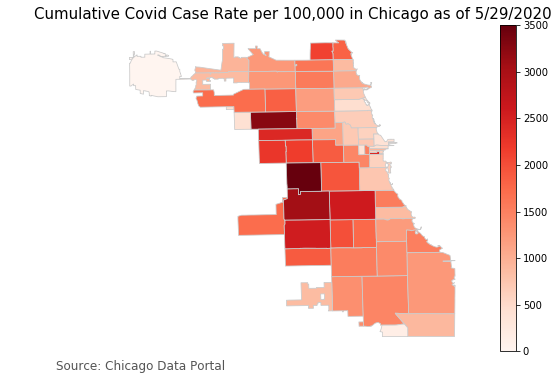

In [44]:
vmin, vmax = 0, 3500
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
merged.plot(ax=ax, column = "Case Rate - Cumulative", cmap = 'Reds', linewidth=0.8,  edgecolor='0.8')
# add a title
ax.set_title('Cumulative Covid Case Rate per 100,000 in Chicago as of 5/29/2020', fontdict={'fontsize': '15', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Chicago Data Portal',xy=(0.1, .08),  
xycoords='figure fraction', horizontalalignment='left', 
verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#fig.savefig('cumulative_covid_caserate_per100k.png', dpi=300)